In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_excel('D:\DATA\stats.xlsx')

# Первичная работа в датасетом

In [3]:
data

,rec_id,rec_date,db_name,schema_name,object_name,object_size,row_count
0,522,2021-10-05,stage,asm,company,40960,100.0
1,523,2021-10-05,stage,asm,monitoring_info,180224,998.0
2,524,2021-10-05,stage,asm,monitoring_info_status,204800,999.0
3,525,2021-10-05,stage,asm,monitoring_object,573440,1000.0
4,526,2021-10-05,stage,ncp,rep_order_status_by_day,647168,5781.0
...,...,...,...,...,...,...,...
4800,5584,2021-10-24,ext_data,public,in_vehicle_ids,16384,0.0
4801,5585,2021-10-24,ext_data,public,out_call_cards,59441152,167762.0
4802,5586,2021-10-24,ext_data,public,out_vehicle,2100183040,10400777.0
4803,5587,2021-10-24,ext_data,NaN,NaN,31166166503,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4805 entries, 0 to 4804
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rec_id       4805 non-null   int64         
 1   rec_date     4805 non-null   datetime64[ns]
 2   db_name      4805 non-null   object        
 3   schema_name  4685 non-null   object        
 4   object_name  4685 non-null   object        
 5   object_size  4805 non-null   int64         
 6   row_count    4685 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 262.9+ KB


In [5]:
np.array(data["db_name"].unique())

array(['stage', 'ext_data', 'dwh', 'disk', 'actuals', 'sandbox'],
      dtype=object)

### Удалим disk из db_name, предварительно сохранив его, т.к. disk показывает размер заполняемой БД 

In [6]:
disk_size = data.loc[data["db_name"] == "disk", "object_size"]
disk_size

192     963085224
1015    963085224
1118    963085224
1341    963085224
1564    963085224
1787    963085224
2013    963085224
2239    963085224
2465    963085224
2691    963085224
2913    963085224
3135    963085224
3357    963085224
3579    963085224
3824    963085224
4069    963085224
4314    963085224
4559    963085224
4804    963085224
Name: object_size, dtype: int64

In [7]:
disk_size = 963085224
disk_size

963085224

In [8]:
data.drop(data[data["db_name"] == 'disk'].index, axis = 0, inplace=True)
np.array(data["db_name"].unique())

array(['stage', 'ext_data', 'dwh', 'actuals', 'sandbox'], dtype=object)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4786 entries, 0 to 4803
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rec_id       4786 non-null   int64         
 1   rec_date     4786 non-null   datetime64[ns]
 2   db_name      4786 non-null   object        
 3   schema_name  4685 non-null   object        
 4   object_name  4685 non-null   object        
 5   object_size  4786 non-null   int64         
 6   row_count    4685 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 299.1+ KB


In [10]:
data.describe()

,rec_id,object_size,row_count
count,4786.000000,4.786000e+03,4.685000e+03
mean,3033.142081,6.235265e+09,1.223261e+07
std,1574.365867,3.375993e+10,5.312849e+07
min,1.000000,8.192000e+03,0.000000e+00
25%,1757.250000,4.096000e+04,1.100000e+01
50%,3184.500000,1.474560e+05,3.560000e+02
75%,4386.750000,1.032937e+09,4.948764e+06
max,5587.000000,3.783724e+11,4.672943e+08


In [11]:
pd.isnull(data).any()

rec_id         False
rec_date       False
db_name        False
schema_name     True
object_name     True
object_size    False
row_count       True
dtype: bool

### Есть незаполненные данные. Посмотрим сколько БД было заполнено в каждый из дней

In [12]:
date_unique = np.array(data["rec_date"].unique())
db_name_array = np.array(data["db_name"].unique())

In [13]:
size_array = []

for date in date_unique:
    val = 0
    for name in db_name_array:
        if data.loc[(data['rec_date'] == date) & (data['db_name'] == name), 'object_size'].sum() > 0:
            val += 1
    size_array.append(val)

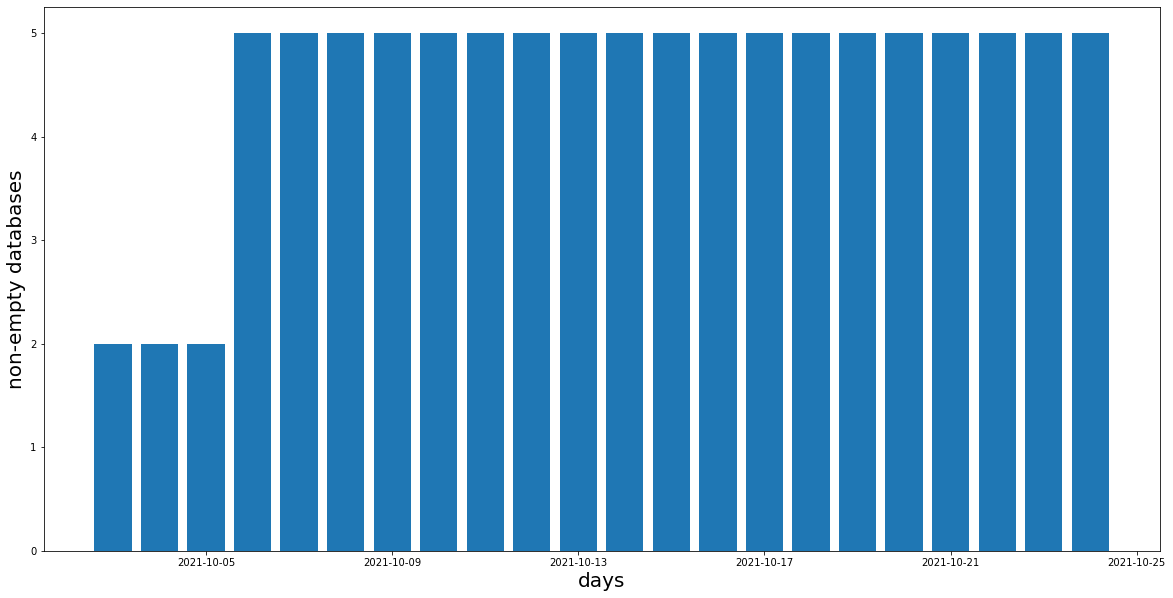

In [14]:
#Показываем сколько баз данных было заполнено в каждый из дней
plt.figure(figsize = (20, 10))

plt.bar(date_unique, size_array)
plt.xlabel("days", fontsize = 20)
plt.ylabel("non-empty databases", fontsize = 20)

plt.show()

### В первые 3 дня заполнены только две БД. Удалим их

In [15]:
for i in range(3, 6):
    data.drop(data[data["rec_date"] == f'2021-10-0{i}'].index, axis = 0, inplace = True)

In [16]:
date_unique = np.array(data["rec_date"].unique())
db_name_array = np.array(data["db_name"].unique())

In [17]:
size_array = []

for date in date_unique:
    val = 0
    for name in db_name_array:
        if data.loc[(data['rec_date'] == date) & (data['db_name'] == name), 'object_size'].sum() > 0:
            val += 1
    size_array.append(val)

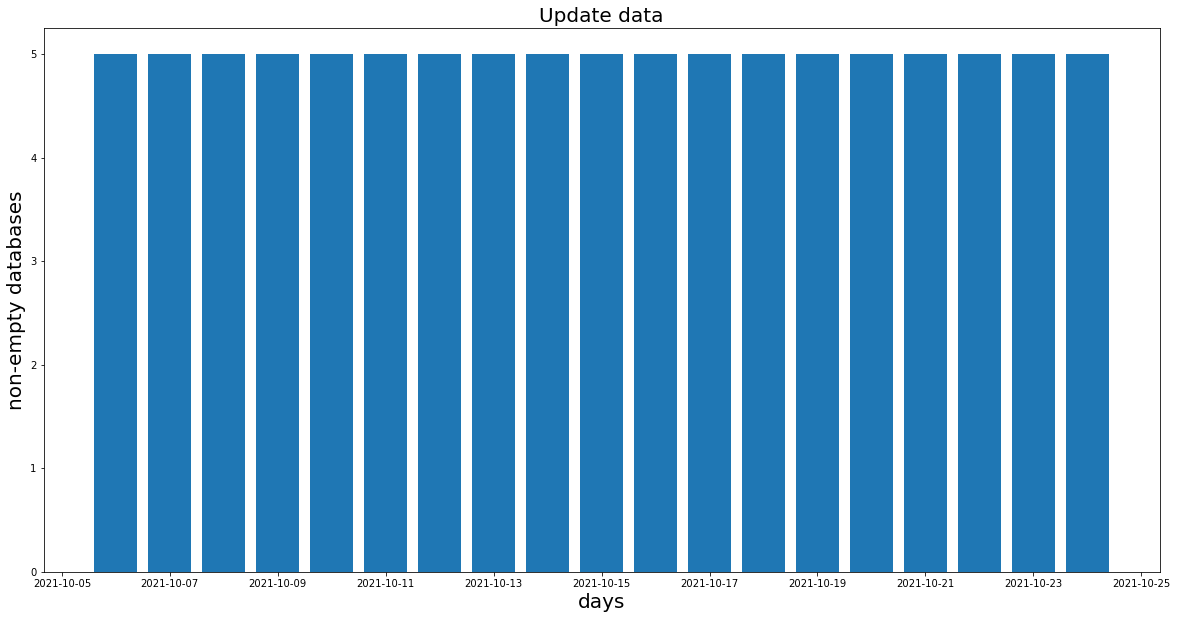

In [18]:
#Показываем сколько баз данных было заполнено в каждый из дней
plt.figure(figsize = (20, 10))

plt.bar(date_unique, size_array)
plt.title("Update data", fontsize = 20)
plt.xlabel("days", fontsize = 20)
plt.ylabel("non-empty databases", fontsize = 20)

plt.show()

# Построим 3 датасета

In [19]:
#Первый датасет
data1 = data[data["object_name"].isnull()]
data1

,rec_id,rec_date,db_name,schema_name,object_name,object_size,row_count
94,1453,2021-10-07,ext_data,NaN,NaN,30781085159,NaN
315,1522,2021-10-08,stage,NaN,NaN,358794229223,NaN
651,1300,2021-10-07,stage,NaN,NaN,357715654119,NaN
652,1436,2021-10-07,actuals,NaN,NaN,285553022439,NaN
756,1437,2021-10-07,sandbox,NaN,NaN,10507751,NaN
...,...,...,...,...,...,...,...
4624,5408,2021-10-24,stage,NaN,NaN,378372388327,NaN
4707,5491,2021-10-24,dwh,NaN,NaN,30601672167,NaN
4760,5544,2021-10-24,actuals,NaN,NaN,328247506407,NaN
4787,5571,2021-10-24,sandbox,NaN,NaN,6892516839,NaN


In [20]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 94 to 4803
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rec_id       95 non-null     int64         
 1   rec_date     95 non-null     datetime64[ns]
 2   db_name      95 non-null     object        
 3   schema_name  0 non-null      object        
 4   object_name  0 non-null      object        
 5   object_size  95 non-null     int64         
 6   row_count    0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 5.9+ KB


In [21]:
data1.describe()

,rec_id,object_size,row_count
count,95.000000,9.500000e+01,0.0
mean,3335.210526,1.461364e+11,NaN
std,1362.904353,1.560346e+11,NaN
min,740.000000,1.050775e+07,NaN
25%,2113.000000,2.987896e+10,NaN
50%,3454.000000,3.096189e+10,NaN
75%,4469.500000,3.048923e+11,NaN
max,5587.000000,3.783724e+11,NaN


In [22]:
#Второй датасет
data2 = data.copy()
data2

,rec_id,rec_date,db_name,schema_name,object_name,object_size,row_count
94,1453,2021-10-07,ext_data,NaN,NaN,30781085159,NaN
240,1233,2021-10-07,stage,asm,company,40960,100.0
241,1234,2021-10-07,stage,asm,monitoring_info,180224,998.0
242,1235,2021-10-07,stage,asm,monitoring_info_status,204800,999.0
243,1236,2021-10-07,stage,asm,monitoring_object,573440,1000.0
...,...,...,...,...,...,...,...
4799,5583,2021-10-24,ext_data,mailbot,subscriptions,49152,2.0
4800,5584,2021-10-24,ext_data,public,in_vehicle_ids,16384,0.0
4801,5585,2021-10-24,ext_data,public,out_call_cards,59441152,167762.0
4802,5586,2021-10-24,ext_data,public,out_vehicle,2100183040,10400777.0


In [23]:
data2["object_name"].replace('', np.nan, inplace=True)
data2.dropna(subset=["object_name"], inplace=True)
data2

,rec_id,rec_date,db_name,schema_name,object_name,object_size,row_count
240,1233,2021-10-07,stage,asm,company,40960,100.0
241,1234,2021-10-07,stage,asm,monitoring_info,180224,998.0
242,1235,2021-10-07,stage,asm,monitoring_info_status,204800,999.0
243,1236,2021-10-07,stage,asm,monitoring_object,573440,1000.0
244,1237,2021-10-07,stage,ncp,rep_order_status_by_day,753664,6807.0
...,...,...,...,...,...,...,...
4798,5582,2021-10-24,ext_data,mailbot,subscription_vins,40960,13.0
4799,5583,2021-10-24,ext_data,mailbot,subscriptions,49152,2.0
4800,5584,2021-10-24,ext_data,public,in_vehicle_ids,16384,0.0
4801,5585,2021-10-24,ext_data,public,out_call_cards,59441152,167762.0


In [24]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4238 entries, 240 to 4802
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   rec_id       4238 non-null   int64         
 1   rec_date     4238 non-null   datetime64[ns]
 2   db_name      4238 non-null   object        
 3   schema_name  4238 non-null   object        
 4   object_name  4238 non-null   object        
 5   object_size  4238 non-null   int64         
 6   row_count    4238 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 264.9+ KB


In [25]:
data2.describe()

,rec_id,object_size,row_count
count,4238.000000,4.238000e+03,4.238000e+03
mean,3314.761916,3.254293e+09,1.248573e+07
std,1376.141643,1.441196e+10,5.380727e+07
min,673.000000,8.192000e+03,0.000000e+00
25%,2096.250000,4.096000e+04,1.100000e+01
50%,3411.500000,1.228800e+05,3.665000e+02
75%,4499.750000,8.238346e+08,5.730296e+06
max,5586.000000,1.356334e+11,4.672943e+08


### Третий датасет будет data. Из него удалены первые 3 дня и disk из db_name


# Объединим в каждом датасете объёмы бд по дням и названию


In [26]:
#Объединение в data1
date_unique = np.array(data1["rec_date"].unique())
db_name_array = np.array(data1["db_name"].unique())
print(date_unique, db_name_array)

['2021-10-07T00:00:00.000000000' '2021-10-08T00:00:00.000000000'
 '2021-10-06T00:00:00.000000000' '2021-10-09T00:00:00.000000000'
 '2021-10-10T00:00:00.000000000' '2021-10-11T00:00:00.000000000'
 '2021-10-12T00:00:00.000000000' '2021-10-13T00:00:00.000000000'
 '2021-10-14T00:00:00.000000000' '2021-10-15T00:00:00.000000000'
 '2021-10-16T00:00:00.000000000' '2021-10-17T00:00:00.000000000'
 '2021-10-18T00:00:00.000000000' '2021-10-19T00:00:00.000000000'
 '2021-10-20T00:00:00.000000000' '2021-10-21T00:00:00.000000000'
 '2021-10-22T00:00:00.000000000' '2021-10-23T00:00:00.000000000'
 '2021-10-24T00:00:00.000000000'] ['ext_data' 'stage' 'actuals' 'sandbox' 'dwh']


In [27]:
size_data1 = []

for date in date_unique:
    for name in db_name_array:
        size_data1.append(data1.loc[(data['rec_date'] == date) & (data1['db_name'] == name), 'object_size'].sum())

size_data1

[30781085159,
 357715654119,
 285553022439,
 10507751,
 29708432871,
 30806562279,
 358794229223,
 286502057447,
 10507751,
 29767628263,
 30756697575,
 356660065767,
 284640122343,
 10507751,
 29647001063,
 30831367655,
 359874983399,
 287445038567,
 10507751,
 29828281831,
 30850037223,
 360813753831,
 288268981735,
 10507751,
 29865514471,
 30865511911,
 361683154407,
 289030919655,
 10507751,
 29892408807,
 30891242983,
 362758264295,
 289353946599,
 10802663,
 29940061671,
 30915663335,
 363864856039,
 299358737895,
 10802663,
 30037480935,
 30939747815,
 365947270631,
 300324681191,
 10802663,
 30101837287,
 30961890791,
 366606685671,
 301299733991,
 10802663,
 30151316967,
 30987023847,
 367179486695,
 302272173543,
 10802663,
 30212183527,
 31004546535,
 368147961319,
 303120815591,
 10802663,
 30247589351,
 31019193831,
 369050015207,
 303579411943,
 10802663,
 30274172391,
 31041844711,
 370144736743,
 304540079591,
 10802663,
 30327772647,
 31051470311,
 373404292583,
 3052

In [28]:
size_ext_data_data1 = size_data1[::5]
size_stage_data1 = size_data1[1::5]
size_actuals_data1 = size_data1[2::5]
size_sandbox_data1 = size_data1[3::5]
size_dwh_data1 = size_data1[4::5]

In [29]:
data_dict = {'date': date_unique,
             'db_ext_size': size_ext_data_data1,
             'db_stage_size': size_stage_data1,
             'db_actuals_size': size_actuals_data1,
             'db_sandbox_size': size_sandbox_data1,
             'db_dwh_size': size_dwh_data1}
data_new_1 = pd.DataFrame(data_dict)
data_new_1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [30]:
data_new_1.sort_values(by='date', inplace = True)
data_new_1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [31]:
#Объединение в data2
date_unique = np.array(data2["rec_date"].unique())
db_name_array = np.array(data2["db_name"].unique())
print(date_unique, db_name_array)

['2021-10-07T00:00:00.000000000' '2021-10-08T00:00:00.000000000'
 '2021-10-06T00:00:00.000000000' '2021-10-09T00:00:00.000000000'
 '2021-10-10T00:00:00.000000000' '2021-10-11T00:00:00.000000000'
 '2021-10-12T00:00:00.000000000' '2021-10-13T00:00:00.000000000'
 '2021-10-14T00:00:00.000000000' '2021-10-15T00:00:00.000000000'
 '2021-10-16T00:00:00.000000000' '2021-10-17T00:00:00.000000000'
 '2021-10-18T00:00:00.000000000' '2021-10-19T00:00:00.000000000'
 '2021-10-20T00:00:00.000000000' '2021-10-21T00:00:00.000000000'
 '2021-10-22T00:00:00.000000000' '2021-10-23T00:00:00.000000000'
 '2021-10-24T00:00:00.000000000'] ['stage' 'actuals' 'dwh' 'ext_data' 'sandbox']


In [32]:
size_data2 = []

for date in date_unique:
    for name in db_name_array:
        size_data2.append(data2.loc[(data['rec_date'] == date) & (data2['db_name'] == name), 'object_size'].sum())

size_data2

[357704269824,
 285542785024,
 24946982912,
 30772961280,
 0,
 358782844928,
 286491803648,
 25006178304,
 30798438400,
 0,
 356648673280,
 284629909504,
 24885559296,
 30748590080,
 0,
 359863582720,
 287434760192,
 25066831872,
 30823243776,
 0,
 360802336768,
 288258703360,
 25104064512,
 30841888768,
 0,
 361671745536,
 289020641280,
 25130598400,
 30857363456,
 0,
 362746585088,
 289343340544,
 25177923584,
 30883028992,
 81920,
 363853176832,
 299348082688,
 25275342848,
 30907449344,
 81920,
 365935599616,
 300314009600,
 25339699200,
 30931533824,
 81920,
 366595006464,
 301288923136,
 25389170688,
 30944026624,
 81920,
 367167750144,
 302261362688,
 25450037248,
 30978859008,
 81920,
 368136241152,
 303110004736,
 25485443072,
 30996365312,
 81920,
 369038286848,
 303568592896,
 25512017920,
 31010988032,
 81920,
 370133008384,
 304529260544,
 25565609984,
 31033638912,
 81920,
 373392564224,
 305233625088,
 25594814464,
 31043264512,
 6881574912,
 374883344384,
 306554576896,

In [33]:
size_stage_data2 = size_data2[::5]
size_actuals_data2 = size_data2[1::5]
size_dwh_data2 = size_data2[2::5]
size_ext_data_data2 = size_data2[3::5]
size_sandbox_data2 = size_data2[4::5]

In [34]:
data_dict = {'date': date_unique,
             'db_ext_size': size_ext_data_data2,
             'db_stage_size': size_stage_data2,
             'db_actuals_size': size_actuals_data2,
             'db_sandbox_size': size_sandbox_data2,
             'db_dwh_size': size_dwh_data2}
data_new_2 = pd.DataFrame(data_dict)
data_new_2

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
0,2021-10-07,30772961280,357704269824,285542785024,0,24946982912
1,2021-10-08,30798438400,358782844928,286491803648,0,25006178304
2,2021-10-06,30748590080,356648673280,284629909504,0,24885559296
3,2021-10-09,30823243776,359863582720,287434760192,0,25066831872
4,2021-10-10,30841888768,360802336768,288258703360,0,25104064512
5,2021-10-11,30857363456,361671745536,289020641280,0,25130598400
6,2021-10-12,30883028992,362746585088,289343340544,81920,25177923584
7,2021-10-13,30907449344,363853176832,299348082688,81920,25275342848
8,2021-10-14,30931533824,365935599616,300314009600,81920,25339699200
9,2021-10-15,30944026624,366595006464,301288923136,81920,25389170688


In [35]:
data_new_2.sort_values(by='date', inplace = True)
data_new_2

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30748590080,356648673280,284629909504,0,24885559296
0,2021-10-07,30772961280,357704269824,285542785024,0,24946982912
1,2021-10-08,30798438400,358782844928,286491803648,0,25006178304
3,2021-10-09,30823243776,359863582720,287434760192,0,25066831872
4,2021-10-10,30841888768,360802336768,288258703360,0,25104064512
5,2021-10-11,30857363456,361671745536,289020641280,0,25130598400
6,2021-10-12,30883028992,362746585088,289343340544,81920,25177923584
7,2021-10-13,30907449344,363853176832,299348082688,81920,25275342848
8,2021-10-14,30931533824,365935599616,300314009600,81920,25339699200
9,2021-10-15,30944026624,366595006464,301288923136,81920,25389170688


In [36]:
#Объединение в data( это будет data3 )
date_unique = np.array(data2["rec_date"].unique())
db_name_array = np.array(data2["db_name"].unique())
print(date_unique, db_name_array)

['2021-10-07T00:00:00.000000000' '2021-10-08T00:00:00.000000000'
 '2021-10-06T00:00:00.000000000' '2021-10-09T00:00:00.000000000'
 '2021-10-10T00:00:00.000000000' '2021-10-11T00:00:00.000000000'
 '2021-10-12T00:00:00.000000000' '2021-10-13T00:00:00.000000000'
 '2021-10-14T00:00:00.000000000' '2021-10-15T00:00:00.000000000'
 '2021-10-16T00:00:00.000000000' '2021-10-17T00:00:00.000000000'
 '2021-10-18T00:00:00.000000000' '2021-10-19T00:00:00.000000000'
 '2021-10-20T00:00:00.000000000' '2021-10-21T00:00:00.000000000'
 '2021-10-22T00:00:00.000000000' '2021-10-23T00:00:00.000000000'
 '2021-10-24T00:00:00.000000000'] ['stage' 'actuals' 'dwh' 'ext_data' 'sandbox']


In [37]:
size_data3 = []

for date in date_unique:
    for name in db_name_array:
        size_data3.append(data.loc[(data['rec_date'] == date) & (data['db_name'] == name), 'object_size'].sum())

size_data3

[715419923943,
 571095807463,
 54655415783,
 61554046439,
 10507751,
 717577074151,
 572993861095,
 54773806567,
 61605000679,
 10507751,
 713308739047,
 569270031847,
 54532560359,
 61505287655,
 10507751,
 719738566119,
 574879798759,
 54895113703,
 61654611431,
 10507751,
 721616090599,
 576527685095,
 54969578983,
 61691925991,
 10507751,
 723354899943,
 578051560935,
 55023007207,
 61722875367,
 10507751,
 725504849383,
 578697287143,
 55117985255,
 61774271975,
 10884583,
 727718032871,
 598706820583,
 55312823783,
 61823112679,
 10884583,
 731882870247,
 600638690791,
 55441536487,
 61871281639,
 10884583,
 733201692135,
 602588657127,
 55540487655,
 61905917415,
 10884583,
 734347236839,
 604533536231,
 55662220775,
 61965882855,
 10884583,
 736284202471,
 606230820327,
 55733032423,
 62000911847,
 10884583,
 738088302055,
 607148004839,
 55786190311,
 62030181863,
 10884583,
 740277745127,
 609069340135,
 55893382631,
 62075483623,
 10884583,
 746796856807,
 610478069223,
 559

In [38]:
size_stage_data3 = size_data3[::5]
size_actuals_data3 = size_data3[1::5]
size_dwh_data3 = size_data3[2::5]
size_ext_data_data3 = size_data3[3::5]
size_sandbox_data3 = size_data3[4::5]

In [39]:
data_dict = {'date': date_unique,
             'db_ext_size': size_ext_data_data3,
             'db_stage_size': size_stage_data3,
             'db_actuals_size': size_actuals_data3,
             'db_sandbox_size': size_sandbox_data3,
             'db_dwh_size': size_dwh_data3}
data_new_3 = pd.DataFrame(data_dict)
data_new_3

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
0,2021-10-07,61554046439,715419923943,571095807463,10507751,54655415783
1,2021-10-08,61605000679,717577074151,572993861095,10507751,54773806567
2,2021-10-06,61505287655,713308739047,569270031847,10507751,54532560359
3,2021-10-09,61654611431,719738566119,574879798759,10507751,54895113703
4,2021-10-10,61691925991,721616090599,576527685095,10507751,54969578983
5,2021-10-11,61722875367,723354899943,578051560935,10507751,55023007207
6,2021-10-12,61774271975,725504849383,578697287143,10884583,55117985255
7,2021-10-13,61823112679,727718032871,598706820583,10884583,55312823783
8,2021-10-14,61871281639,731882870247,600638690791,10884583,55441536487
9,2021-10-15,61905917415,733201692135,602588657127,10884583,55540487655


In [40]:
data_new_3.sort_values(by='date', inplace = True)
data_new_3

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,61505287655,713308739047,569270031847,10507751,54532560359
0,2021-10-07,61554046439,715419923943,571095807463,10507751,54655415783
1,2021-10-08,61605000679,717577074151,572993861095,10507751,54773806567
3,2021-10-09,61654611431,719738566119,574879798759,10507751,54895113703
4,2021-10-10,61691925991,721616090599,576527685095,10507751,54969578983
5,2021-10-11,61722875367,723354899943,578051560935,10507751,55023007207
6,2021-10-12,61774271975,725504849383,578697287143,10884583,55117985255
7,2021-10-13,61823112679,727718032871,598706820583,10884583,55312823783
8,2021-10-14,61871281639,731882870247,600638690791,10884583,55441536487
9,2021-10-15,61905917415,733201692135,602588657127,10884583,55540487655


In [41]:
data_new_2

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30748590080,356648673280,284629909504,0,24885559296
0,2021-10-07,30772961280,357704269824,285542785024,0,24946982912
1,2021-10-08,30798438400,358782844928,286491803648,0,25006178304
3,2021-10-09,30823243776,359863582720,287434760192,0,25066831872
4,2021-10-10,30841888768,360802336768,288258703360,0,25104064512
5,2021-10-11,30857363456,361671745536,289020641280,0,25130598400
6,2021-10-12,30883028992,362746585088,289343340544,81920,25177923584
7,2021-10-13,30907449344,363853176832,299348082688,81920,25275342848
8,2021-10-14,30931533824,365935599616,300314009600,81920,25339699200
9,2021-10-15,30944026624,366595006464,301288923136,81920,25389170688


In [42]:
data_new_1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


# Выберем датасет, с которым будем работать


### Выбирать будем между data_new_1 и data_new_3, т.к. в data_new_2 есть нулевые значения в db_sandbox_size и слишком большие выбросы

### Смотреть будем по db_sandbox_size, т.к. все остальные колонки схожи

<AxesSubplot:>

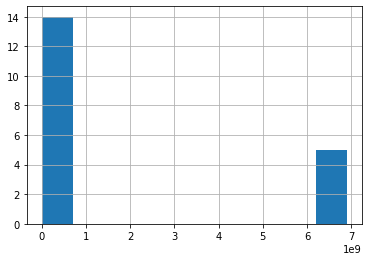

In [43]:
data_new_1["db_sandbox_size"].hist()

<AxesSubplot:>

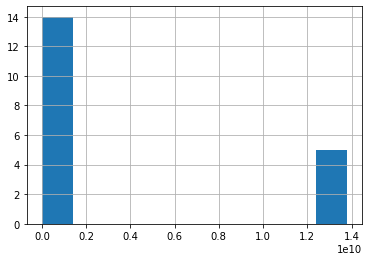

In [44]:
data_new_3["db_sandbox_size"].hist()

<AxesSubplot:title={'center':'data_new_1'}>

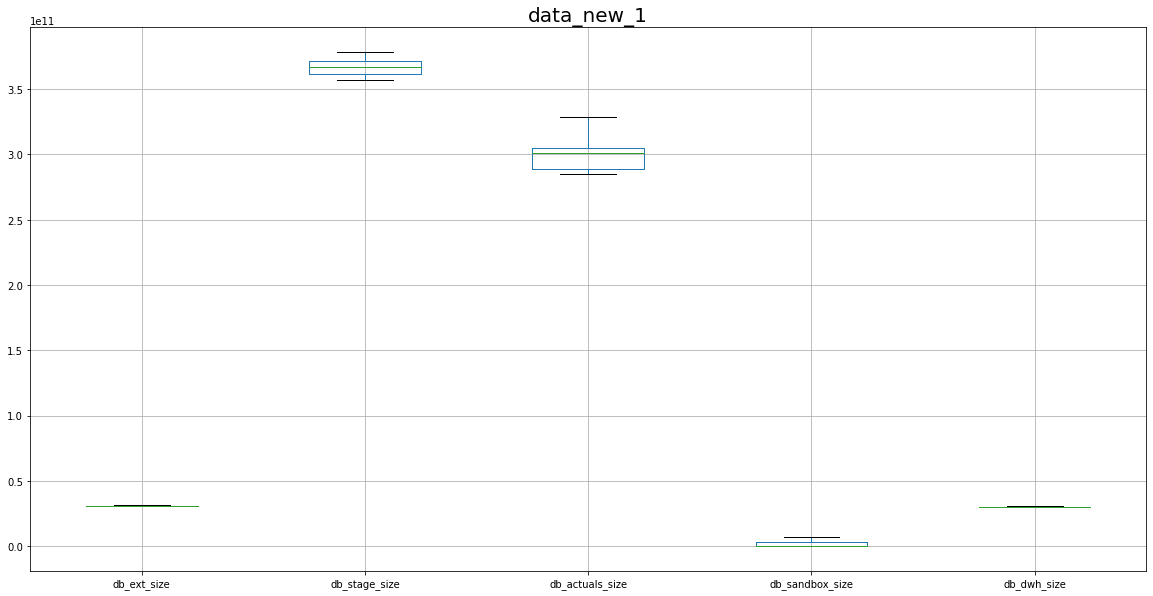

In [49]:
plt.figure(figsize = (20, 10))
plt.title("data_new_1", fontsize = 20)
data_new_1.boxplot()

<AxesSubplot:title={'center':'data_new_3'}>

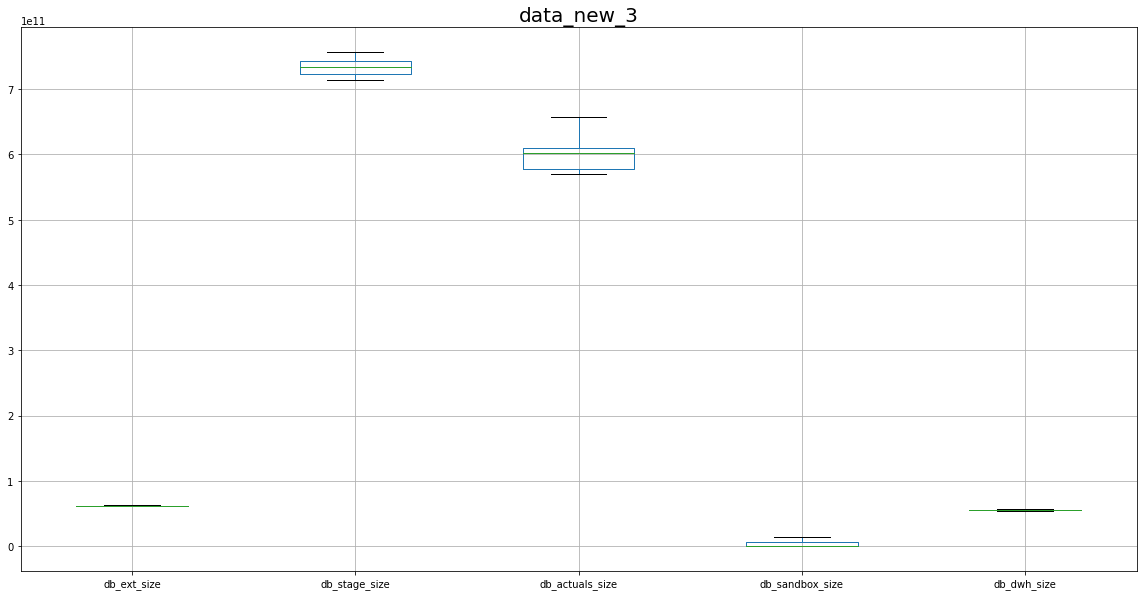

In [50]:
plt.figure(figsize = (20, 10))
plt.title("data_new_3", fontsize = 20)
data_new_3.boxplot()

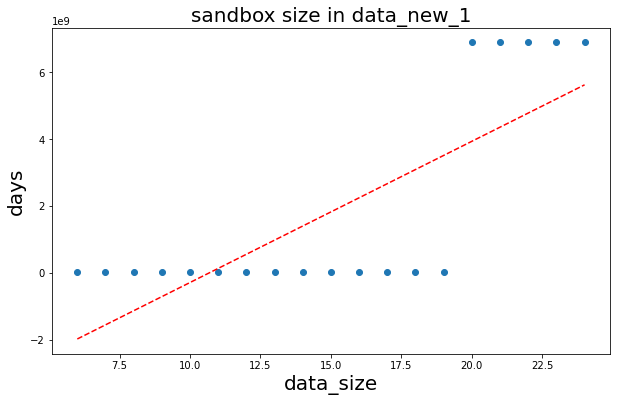

In [52]:
plt.figure(figsize = (10, 6))

x = np.arange(6, 25, 1)
y = data_new_1["db_sandbox_size"]

plt.scatter(x, y)

plt.title("sandbox size in data_new_1", fontsize = 20)
plt.xlabel("data_size", fontsize = 20)
plt.ylabel("days", fontsize = 20)

#линия тренда
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

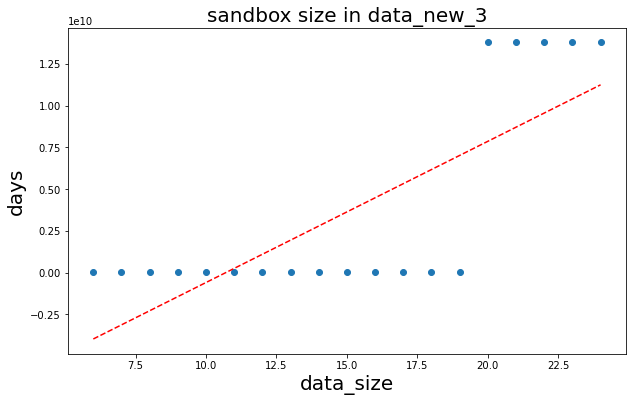

In [53]:
plt.figure(figsize = (10, 6))

x = np.arange(6, 25, 1)
y = data_new_3["db_sandbox_size"]

plt.scatter(x, y)

plt.title("sandbox size in data_new_3", fontsize = 20)
plt.xlabel("data_size", fontsize = 20)
plt.ylabel("days", fontsize = 20)

#линия тренда
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

# Графики выглядят одинаково, выберем data_new_1, т.к. там разброс меньше на 1 порядок

# Уберем выбросы в data_new_1 в столбце db_sandbox_size


In [54]:
data_new_1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


<AxesSubplot:>

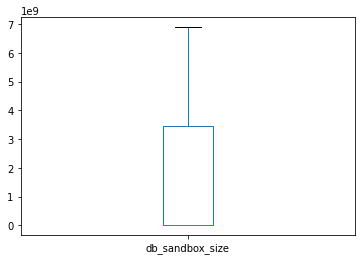

In [55]:
data_new_1['db_sandbox_size'].plot(kind='box')

In [56]:
data_new_1["db_sandbox_size"].describe()

count    1.900000e+01
mean     1.821686e+09
std      3.113439e+09
min      1.050775e+07
25%      1.050775e+07
50%      1.080266e+07
75%      3.451656e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

In [92]:
mean_val = data_new_1["db_sandbox_size"].describe()
mean_val['mean']

1821686085.3157895

### 1) Запишем среднее значение в первые 14 элементов и посчитаем регрессию

In [93]:
df = data_new_1.copy()
df

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [94]:
df.loc[(data_new_1.db_sandbox_size == 10507751) | (data_new_1.db_sandbox_size == 10802663), "db_sandbox_size"] = mean_val['mean']
df

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,1.821686e+09,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,1.821686e+09,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,1.821686e+09,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,1.821686e+09,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,1.821686e+09,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,1.821686e+09,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,1.821686e+09,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,1.821686e+09,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,1.821686e+09,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,1.821686e+09,30151316967


In [95]:
y = df["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

regr_sandbox_1_14 = LinearRegression()
regr_sandbox_1_14.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', regr_sandbox_1_14.score(x, y))
print('Intecept:', regr_sandbox_1_14.intercept_)
print('Coef:', regr_sandbox_1_14.coef_)

data r-squared: 0.583333494884391
Intecept: 353814585.54404354
Coef: [3.11366643e+08]


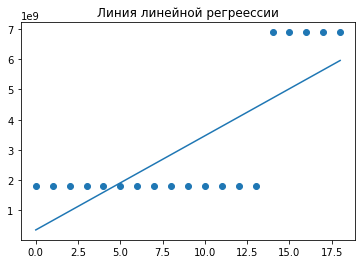

In [96]:
plt.scatter(x, df["db_sandbox_size"])
plt.plot(x, regr_sandbox_1_14.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [97]:
df["db_sandbox_size"].describe()

count    1.900000e+01
mean     3.156114e+09
std      2.294113e+09
min      1.821686e+09
25%      1.821686e+09
50%      1.821686e+09
75%      4.357097e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

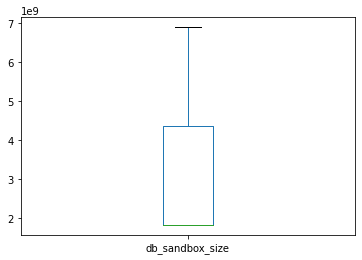

In [98]:
df['db_sandbox_size'].plot(kind='box')

### 1) Запишем среднее значение в последние 5 элементов и посчитаем регрессию

In [99]:
df1 = data_new_1.copy()
df1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [100]:
df1.loc[(data_new_1.db_sandbox_size == 6892508647) | (data_new_1.db_sandbox_size == 6892516839), "db_sandbox_size"] = mean_val['mean']
df1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,1.050775e+07,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,1.050775e+07,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,1.050775e+07,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,1.050775e+07,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,1.050775e+07,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,1.050775e+07,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,1.080266e+07,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,1.080266e+07,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,1.080266e+07,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,1.080266e+07,30151316967


In [101]:
y = df1["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

regr_sandbox_15_19 = LinearRegression()
regr_sandbox_15_19.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', regr_sandbox_15_19.score(x, y))
print('Intecept:', regr_sandbox_15_19.intercept_)
print('Coef:', regr_sandbox_15_19.coef_)

data r-squared: 0.58346360137187
Intecept: -513675166.7440444
Coef: [1.11214774e+08]


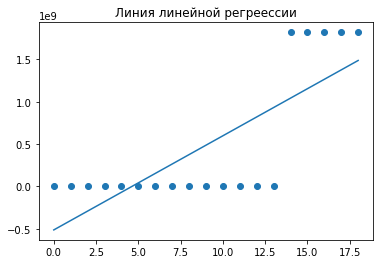

In [102]:
plt.scatter(x, df1["db_sandbox_size"])
plt.plot(x, regr_sandbox_15_19.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [103]:
df1["db_sandbox_size"].describe()

count    1.900000e+01
mean     4.872578e+08
std      8.193261e+08
min      1.050775e+07
25%      1.050775e+07
50%      1.080266e+07
75%      9.162444e+08
max      1.821686e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

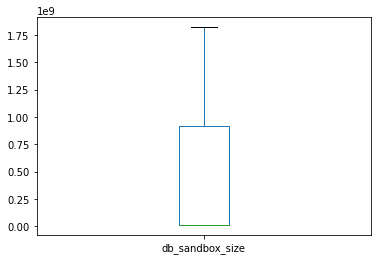

In [104]:
df1['db_sandbox_size'].plot(kind='box')

### Посчитаем линейную регрессию, чтобы сравнить с этими двумя

In [105]:
data_new_1

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [106]:
y = data_new_1["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

regr_sandbox_origin = LinearRegression()
regr_sandbox_origin.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', regr_sandbox_origin.score(x, y))
print('Intecept:', regr_sandbox_origin.intercept_)
print('Coef:', regr_sandbox_origin.coef_)

data r-squared: 0.5833677348191076
Intecept: -1981546666.5157902
Coef: [4.22581417e+08]


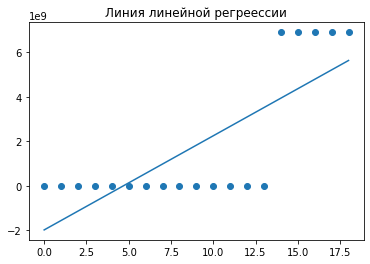

In [107]:
plt.scatter(x, data_new_1["db_sandbox_size"])
plt.plot(x, regr_sandbox_origin.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [108]:
data_new_1["db_sandbox_size"].describe()

count    1.900000e+01
mean     1.821686e+09
std      3.113439e+09
min      1.050775e+07
25%      1.050775e+07
50%      1.080266e+07
75%      3.451656e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

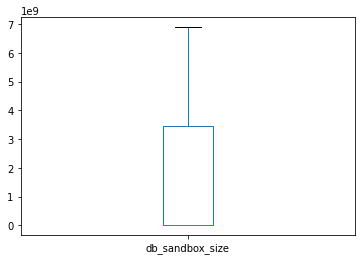

In [109]:
data_new_1['db_sandbox_size'].plot(kind='box')

### Видим, что после преобразований модель немного улучшилось, но незначительно. Будем ещё делать преобразования

### Попробуем подставить верхний процентиль в первые 14 значений

In [112]:
df2 = data_new_1.copy()
df2

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,10507751,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,10507751,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,10507751,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,10507751,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,10507751,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,10507751,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [113]:
df2.loc[(data_new_1.db_sandbox_size == 10507751) | (data_new_1.db_sandbox_size == 10802663), "db_sandbox_size"] = mean_val['75%']
df2

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,3.451656e+09,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,3.451656e+09,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,3.451656e+09,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,3.451656e+09,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,3.451656e+09,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,3.451656e+09,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,3.451656e+09,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,3.451656e+09,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,3.451656e+09,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,3.451656e+09,30151316967


In [114]:
y = df2["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

regr_sandbox_75 = LinearRegression()
regr_sandbox_75.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', regr_sandbox_75.score(x, y))
print('Intecept:', regr_sandbox_75.intercept_)
print('Coef:', regr_sandbox_75.coef_)

data r-squared: 0.5833335714124404
Intecept: 2455617451.71579
Coef: [2.11280792e+08]


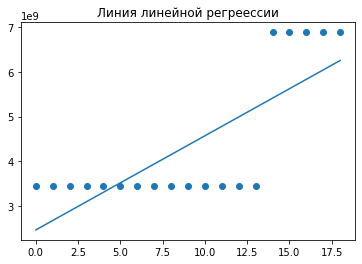

In [115]:
plt.scatter(x, df2["db_sandbox_size"])
plt.plot(x, regr_sandbox_75.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [116]:
df2["db_sandbox_size"].describe()

count    1.900000e+01
mean     4.357145e+09
std      1.556692e+09
min      3.451656e+09
25%      3.451656e+09
50%      3.451656e+09
75%      5.172082e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

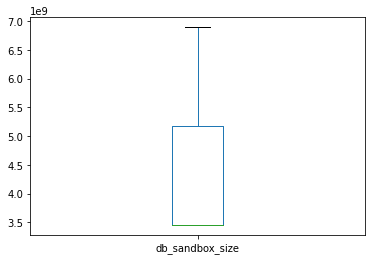

In [117]:
df2['db_sandbox_size'].plot(kind='box')

### Заменим первые 14 значений, минусуя их из 15-го значения столбца db_sandbox_size

In [120]:
Data = data_new_1.copy()

In [121]:
Data.loc[data_new_1.db_sandbox_size == 10507751, "db_sandbox_size"] = 6892508647 - 10507751
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6882000896,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6882000896,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6882000896,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,10802663,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,10802663,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,10802663,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,10802663,30151316967


In [122]:
Data.loc[data_new_1.db_sandbox_size == 10802663, "db_sandbox_size"] = 6892508647 - (10802663 - 10507751)
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6882000896,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6882000896,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6882000896,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6892213735,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [126]:
y = Data["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

model_sandbox = LinearRegression()
model_sandbox.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_sandbox.score(x, y))
print('Intecept:', model_sandbox.intercept_)
print('Coef:', model_sandbox.coef_)

data r-squared: 0.6691551537061753
Intecept: 6882612489.06842
Coef: [717226.75263158]


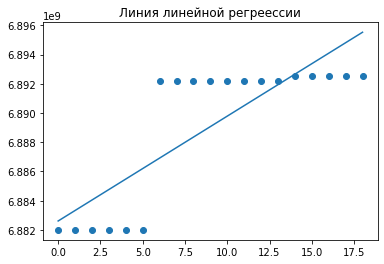

In [131]:
plt.scatter(x, Data["db_sandbox_size"])
plt.plot(x, model_sandbox.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [127]:
Data["db_sandbox_size"].describe()

count    1.900000e+01
mean     6.889068e+09
std      4.933944e+06
min      6.882001e+09
25%      6.882001e+09
50%      6.892214e+09
75%      6.892361e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

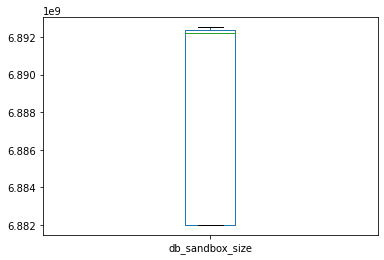

In [128]:
Data['db_sandbox_size'].plot(kind='box')

### Добавим больше промежуточных значений, так как коэфициент детерминации у модели плохой из-за того, что много одинаковых данных

In [132]:
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6882000896,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6882000896,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6882000896,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6892213735,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [136]:
mean_val_1 = int(6882000896 + ((6892213735 - 6882000896) / 2))
mean_val_1

6887107315

In [138]:
mean_val_2 = int(6892213735 + ((6892508647 - 6892213735) / 2))
mean_val_2

6892361191

In [166]:
for i in range(3, 7):
    Data['db_sandbox_size'].iloc[i] = mean_val_1
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6887107315,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [167]:
for i in range(11, 14):
    Data['db_sandbox_size'].iloc[i] = mean_val_2
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6887107315,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


### Снова посмотроим линейную регрессию

In [168]:
y = Data["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

model_sandbox = LinearRegression()
model_sandbox.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_sandbox.score(x, y))
print('Intecept:', model_sandbox.intercept_)
print('Coef:', model_sandbox.coef_)

data r-squared: 0.7344702231978901
Intecept: 6884119867.031579
Coef: [612051.45263158]


### Снова добавим промежуточных значений

In [173]:
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6887107315,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [174]:
Data['db_sandbox_size'].iloc[3] = int((6887107315 + 6882000896) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [175]:
Data['db_sandbox_size'].iloc[16] = int((6892508647 + 6892516839) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6882000896,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6882000896,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [178]:
Data['db_sandbox_size'].iloc[2] = int((6882000896 + 6884554105) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892213735,30151316967


In [180]:
for i in range(9, 11):
    Data['db_sandbox_size'].iloc[i] = int((6892213735 + 6892361191) / 2)
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


In [186]:
Data['db_sandbox_size'].iloc[13] = int((6892508647 + 6892361191) / 2)
Data

,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6887107315,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6892213735,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


In [187]:
for i in range(6, 8):
    Data['db_sandbox_size'].iloc[i] = int((6892213735 + 6887107315) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6889660525,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6892213735,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


### Снова посмотроим линейную регрессию

In [188]:
y = Data["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

model_sandbox = LinearRegression()
model_sandbox.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_sandbox.score(x, y))
print('Intecept:', model_sandbox.intercept_)
print('Coef:', model_sandbox.coef_)

data r-squared: 0.7853711762925032
Intecept: 6884226709.063158
Coef: [601449.6245614]


### Проведем финальное сглаживание 

In [189]:
for i in range(7, 9):
    Data['db_sandbox_size'].iloc[i] = int((6889660525 + 6892213735) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6887107315,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6890937130,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6890937130,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


In [191]:
Data['db_sandbox_size'].iloc[4] = int((6887107315 + 6884554105) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6885830710,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6890937130,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6890937130,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


### Построим предфинальный вариант линейной регрессии для db_sandbox_size

In [192]:
y = Data["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

model_sandbox = LinearRegression()
model_sandbox.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_sandbox.score(x, y))
print('Intecept:', model_sandbox.intercept_)
print('Coef:', model_sandbox.coef_)

data r-squared: 0.7945650916544523
Intecept: 6884078891.642105
Coef: [610408.25614035]


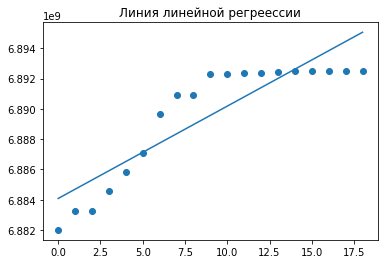

In [193]:
plt.scatter(x, Data["db_sandbox_size"])
plt.plot(x, model_sandbox.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [194]:
Data["db_sandbox_size"].describe()

count    1.900000e+01
mean     6.889573e+09
std      3.853513e+06
min      6.882001e+09
25%      6.886469e+09
50%      6.892287e+09
75%      6.892472e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

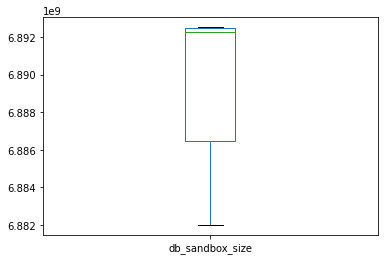

In [195]:
Data['db_sandbox_size'].plot(kind='box')

### Произведем усреднение в верхней части стобца

In [198]:
Data['db_sandbox_size'].iloc[17] = int((6892516839 + 6892512743) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6885830710,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6890937130,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6890937130,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


In [199]:
Data['db_sandbox_size'].iloc[14] = int((6892508647 + 6892434919) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6885830710,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6890937130,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6890937130,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


In [200]:
Data['db_sandbox_size'].iloc[11] = int((6892287463 + 6892361191) / 2)
Data

D:\anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,date,db_ext_size,db_stage_size,db_actuals_size,db_sandbox_size,db_dwh_size
2,2021-10-06,30756697575,356660065767,284640122343,6882000896,29647001063
0,2021-10-07,30781085159,357715654119,285553022439,6883277500,29708432871
1,2021-10-08,30806562279,358794229223,286502057447,6883277500,29767628263
3,2021-10-09,30831367655,359874983399,287445038567,6884554105,29828281831
4,2021-10-10,30850037223,360813753831,288268981735,6885830710,29865514471
5,2021-10-11,30865511911,361683154407,289030919655,6887107315,29892408807
6,2021-10-12,30891242983,362758264295,289353946599,6889660525,29940061671
7,2021-10-13,30915663335,363864856039,299358737895,6890937130,30037480935
8,2021-10-14,30939747815,365947270631,300324681191,6890937130,30101837287
9,2021-10-15,30961890791,366606685671,301299733991,6892287463,30151316967


### Построим финальный вариант линейной регрессии для db_sandbox_size

In [217]:
y = Data["db_sandbox_size"]
x = np.arange(19).reshape(-1, 1)

model_sandbox = LinearRegression()
model_sandbox.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_sandbox.score(x, y))
print('Intecept:', model_sandbox.intercept_)
print('Coef:', model_sandbox.coef_)

data r-squared: 0.7945955326109079
Intecept: 6884079236.568421
Coef: [609926.79649123]


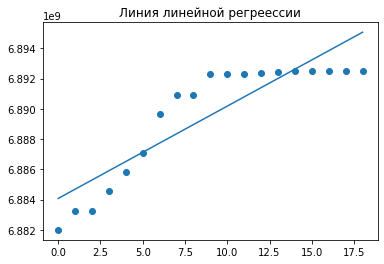

In [218]:
plt.scatter(x, Data["db_sandbox_size"])
plt.plot(x, model_sandbox.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [219]:
Data["db_sandbox_size"].describe()

count    1.900000e+01
mean     6.889569e+09
std      3.850400e+06
min      6.882001e+09
25%      6.886469e+09
50%      6.892287e+09
75%      6.892453e+09
max      6.892517e+09
Name: db_sandbox_size, dtype: float64

<AxesSubplot:>

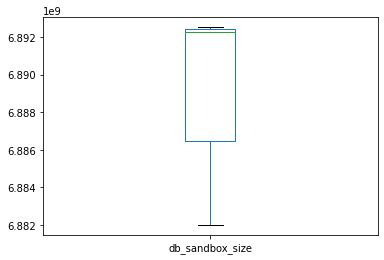

In [220]:
Data['db_sandbox_size'].plot(kind='box')

### Модель больше практически не изменяется

# Посмотрим её остатки

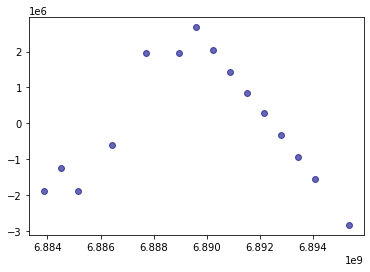

In [226]:
size = Data["db_sandbox_size"]
x_range = np.arange(19).reshape(-1, 1)

X_train, x_test, Y_train, y_test = train_test_split(x_range, size, test_size = 0.2, random_state = 10)

# Используем Statsmodel
x_incl_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_const)
results = model.fit()

#Residuals vs Predicted values
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)

plt.show()

### Остатки разбросаны почти рандомно. Перейдем к другим моделям

# Построим модель линейной регрессии для db_ext_size

In [222]:
y = Data["db_ext_size"]
x = np.arange(19).reshape(-1, 1)

model_ext_data = LinearRegression()
model_ext_data.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_ext_data.score(x, y))
print('Intecept:', model_ext_data.intercept_)
print('Coef:', model_ext_data.coef_)

data r-squared: 0.9973360626129781
Intecept: 30758737857.273685
Coef: [22336752.72982457]


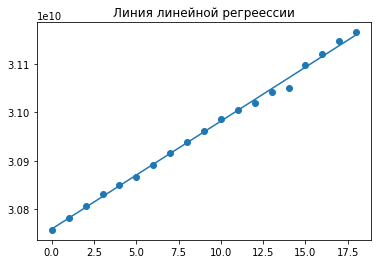

In [223]:
plt.scatter(x, Data["db_ext_size"])
plt.plot(x, model_ext_data.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [224]:
Data["db_ext_size"].describe()

count    1.900000e+01
mean     3.095977e+10
std      1.258637e+08
min      3.075670e+10
25%      3.085777e+10
50%      3.096189e+10
75%      3.104666e+10
max      3.116617e+10
Name: db_ext_size, dtype: float64

<AxesSubplot:>

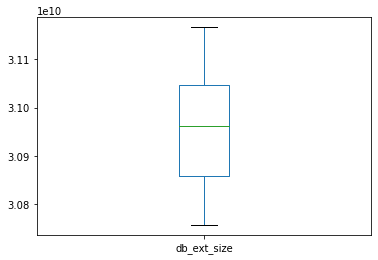

In [225]:
Data['db_ext_size'].plot(kind='box')

# Остатки db_ext_size

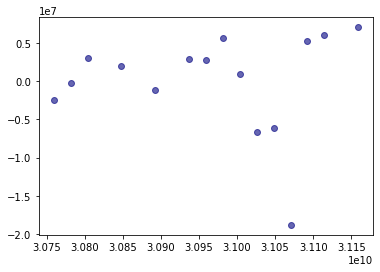

In [227]:
size = Data["db_ext_size"]
x_range = np.arange(19).reshape(-1, 1)

X_train, x_test, Y_train, y_test = train_test_split(x_range, size, test_size = 0.2, random_state = 10)

# Используем Statsmodel
x_incl_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_const)
results = model.fit()

#Residuals vs Predicted values
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)

plt.show()

# Построим модель линейной регрессии для db_stage_size

In [234]:
y = Data["db_stage_size"]
x = np.arange(19).reshape(-1, 1)

model_stage = LinearRegression()
model_stage.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_stage.score(x, y))
print('Intecept:', model_stage.intercept_)
print('Coef:', model_stage.coef_)

data r-squared: 0.987315133024605
Intecept: 355931406079.2526
Coef: [1.20811839e+09]


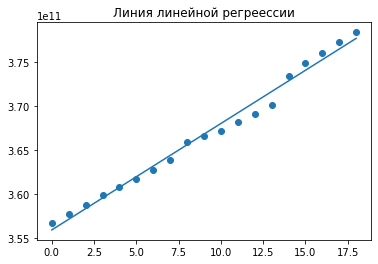

In [254]:
plt.scatter(x, Data["db_stage_size"])
plt.plot(x, model_stage.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [236]:
Data["db_stage_size"].describe()

count    1.900000e+01
mean     3.668045e+11
std      6.841995e+09
min      3.566601e+11
25%      3.612485e+11
50%      3.666067e+11
75%      3.717745e+11
max      3.783724e+11
Name: db_stage_size, dtype: float64

<AxesSubplot:>

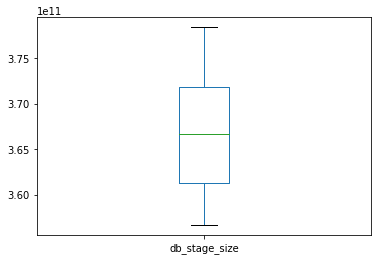

In [237]:
Data['db_stage_size'].plot(kind='box')

# Остатки db_stage_size

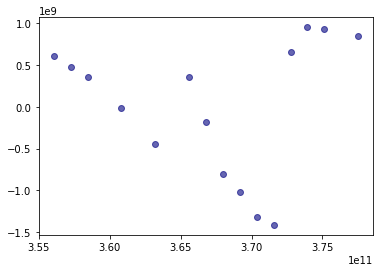

In [238]:
size = Data["db_stage_size"]
x_range = np.arange(19).reshape(-1, 1)

X_train, x_test, Y_train, y_test = train_test_split(x_range, size, test_size = 0.2, random_state = 10)

# Используем Statsmodel
x_incl_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_const)
results = model.fit()

#Residuals vs Predicted values
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)

plt.show()

# Построим модель линейной регрессии для db_actuals_size

In [239]:
y = Data["db_actuals_size"]
x = np.arange(19).reshape(-1, 1)

model_actuals = LinearRegression()
model_actuals.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_actuals.score(x, y))
print('Intecept:', model_actuals.intercept_)
print('Coef:', model_actuals.coef_)

data r-squared: 0.8754106921336862
Intecept: 280210297049.5263
Coef: [2.30623642e+09]


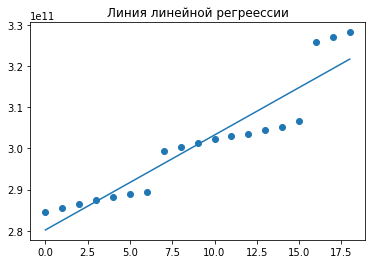

In [255]:
plt.scatter(x, Data["db_actuals_size"])
plt.plot(x, model_actuals.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [242]:
Data["db_actuals_size"].describe()

count    1.900000e+01
mean     3.009664e+11
std      1.387072e+10
min      2.846401e+11
25%      2.886500e+11
50%      3.012997e+11
75%      3.048923e+11
max      3.282475e+11
Name: db_actuals_size, dtype: float64

<AxesSubplot:>

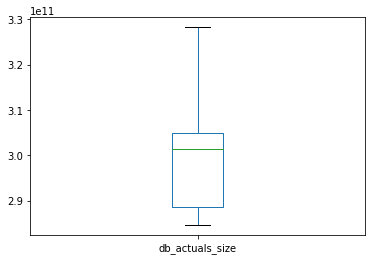

In [243]:
Data['db_actuals_size'].plot(kind='box')

# Остатки db_actuals_size

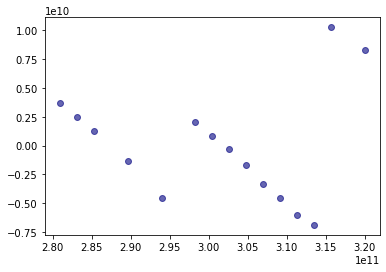

In [244]:
size = Data["db_actuals_size"]
x_range = np.arange(19).reshape(-1, 1)

X_train, x_test, Y_train, y_test = train_test_split(x_range, size, test_size = 0.2, random_state = 10)

# Используем Statsmodel
x_incl_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_const)
results = model.fit()

#Residuals vs Predicted values
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)

plt.show()

# Построим модель линейной регрессии для db_dwh_size

In [245]:
y = Data["db_dwh_size"]
x = np.arange(19).reshape(-1, 1)

model_dwh = LinearRegression()
model_dwh.fit(x, y)

#Коэффициент детерминации, который показывает на сколько точная модель
print('data r-squared:', model_dwh.score(x, y))
print('Intecept:', model_dwh.intercept_)
print('Coef:', model_dwh.coef_)

data r-squared: 0.9960701145291562
Intecept: 29656603639.168423
Coef: [52573209.1508772]


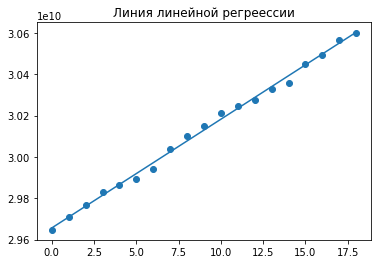

In [256]:
plt.scatter(x, Data["db_dwh_size"])
plt.plot(x, model_dwh.predict(x))

plt.title("Линия линейной регреессии")

plt.show()

In [250]:
Data["db_dwh_size"].describe()

count    1.900000e+01
mean     3.012976e+10
std      2.964290e+08
min      2.964700e+10
25%      2.987896e+10
50%      3.015132e+10
75%      3.034237e+10
max      3.060167e+10
Name: db_dwh_size, dtype: float64

<AxesSubplot:>

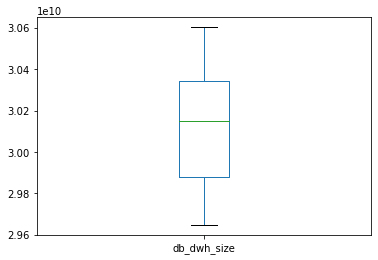

In [251]:
Data['db_dwh_size'].plot(kind='box')

# Остатки db_dwh_size

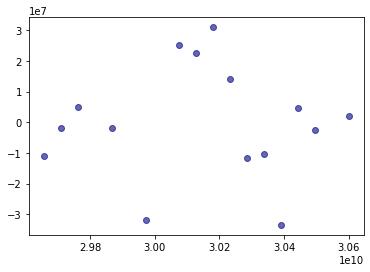

In [252]:
size = Data["db_dwh_size"]
x_range = np.arange(19).reshape(-1, 1)

X_train, x_test, Y_train, y_test = train_test_split(x_range, size, test_size = 0.2, random_state = 10)

# Используем Statsmodel
x_incl_const = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_const)
results = model.fit()

#Residuals vs Predicted values
plt.scatter(x = results.fittedvalues, y = results.resid, c = 'navy', alpha = 0.6)

plt.show()

# определения суммарного объем БД

In [311]:
%time
def database_size(days: int) -> None:
    '''
    The function calculates size 
    of the database for a given
    period of time
    '''
    X = np.arange(days).reshape(-1, 1)
    
    actual = np.array(model_actuals.predict(X))
    dwh = np.array(model_dwh.predict(X))
    stage = np.array(model_stage.predict(X))
    ext = np.array(model_ext_data.predict(X))
    sandbox = np.array(model_sandbox.predict(X))
    
    all_predict = actual + dwh + stage + ext + sandbox
    db_all_size_predict = round(all_predict.sum(), 3)
    
    #График
    plt.figure(figsize = (25, 15))
    plt.scatter(X, all_predict)
    plt.plot(X, all_predict)
    
    plt.xlabel("Days", fontsize = 20)
    plt.ylabel("Database size", fontsize = 20)
    plt.title(f"Database size: {db_all_size_predict}", fontsize = 20)

    plt.show()
    
    return db_all_size_predict

Wall time: 0 ns


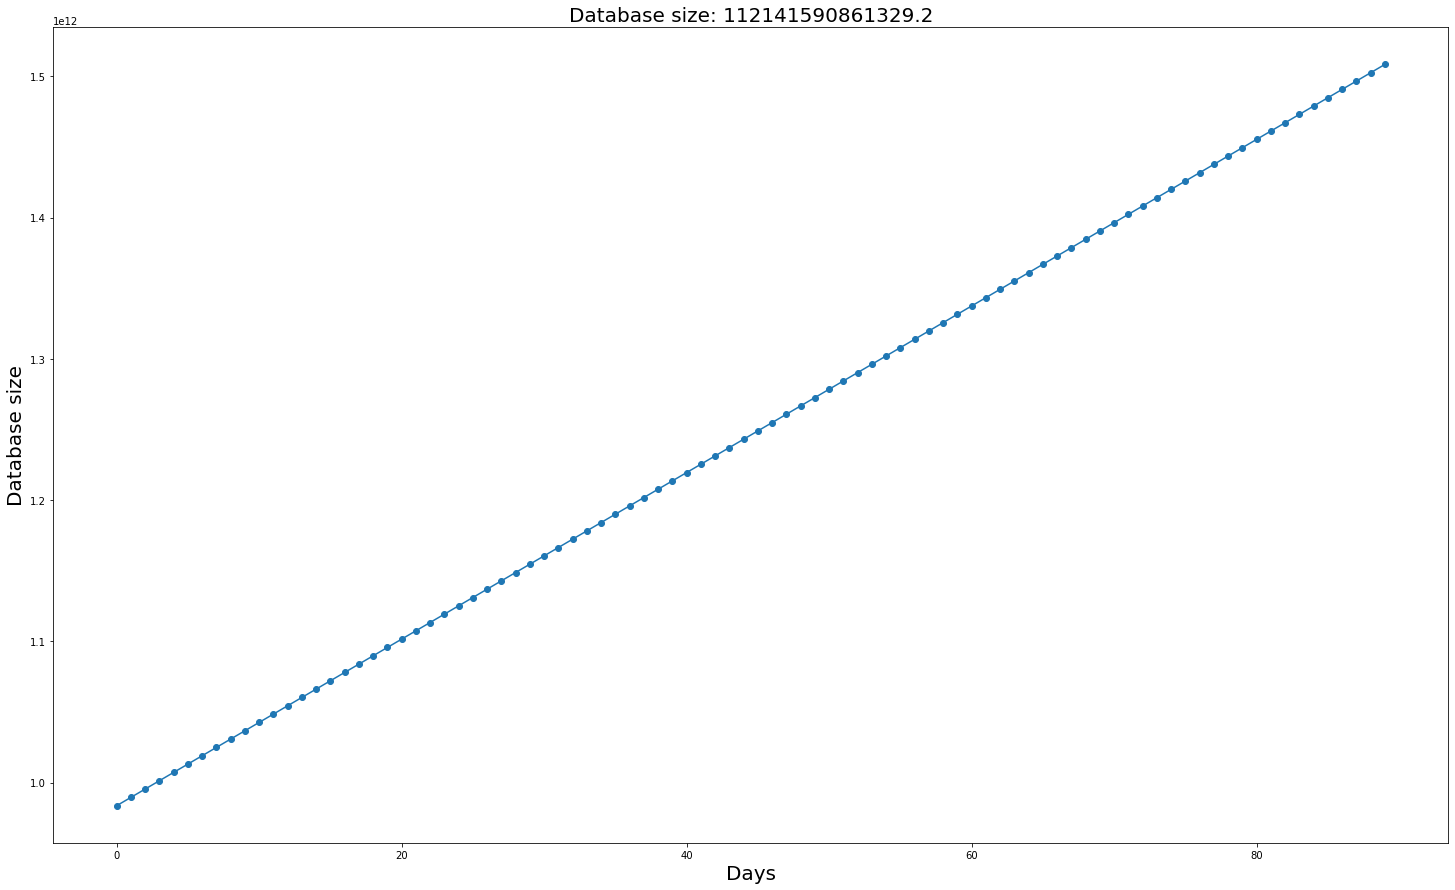

112141590861329.2

In [312]:
database_size(90)

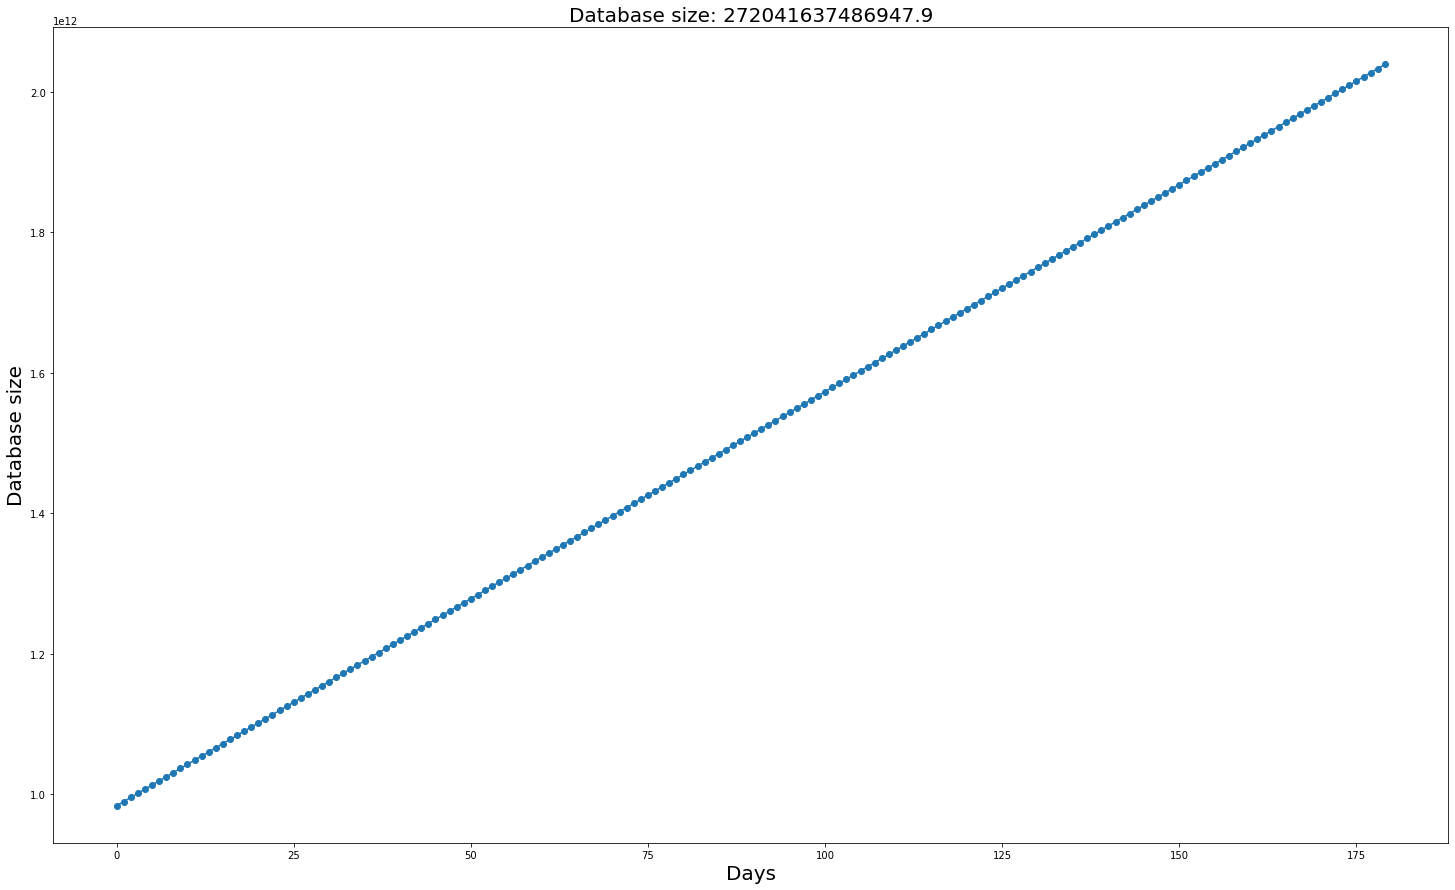

272041637486947.9

In [313]:
database_size(180)

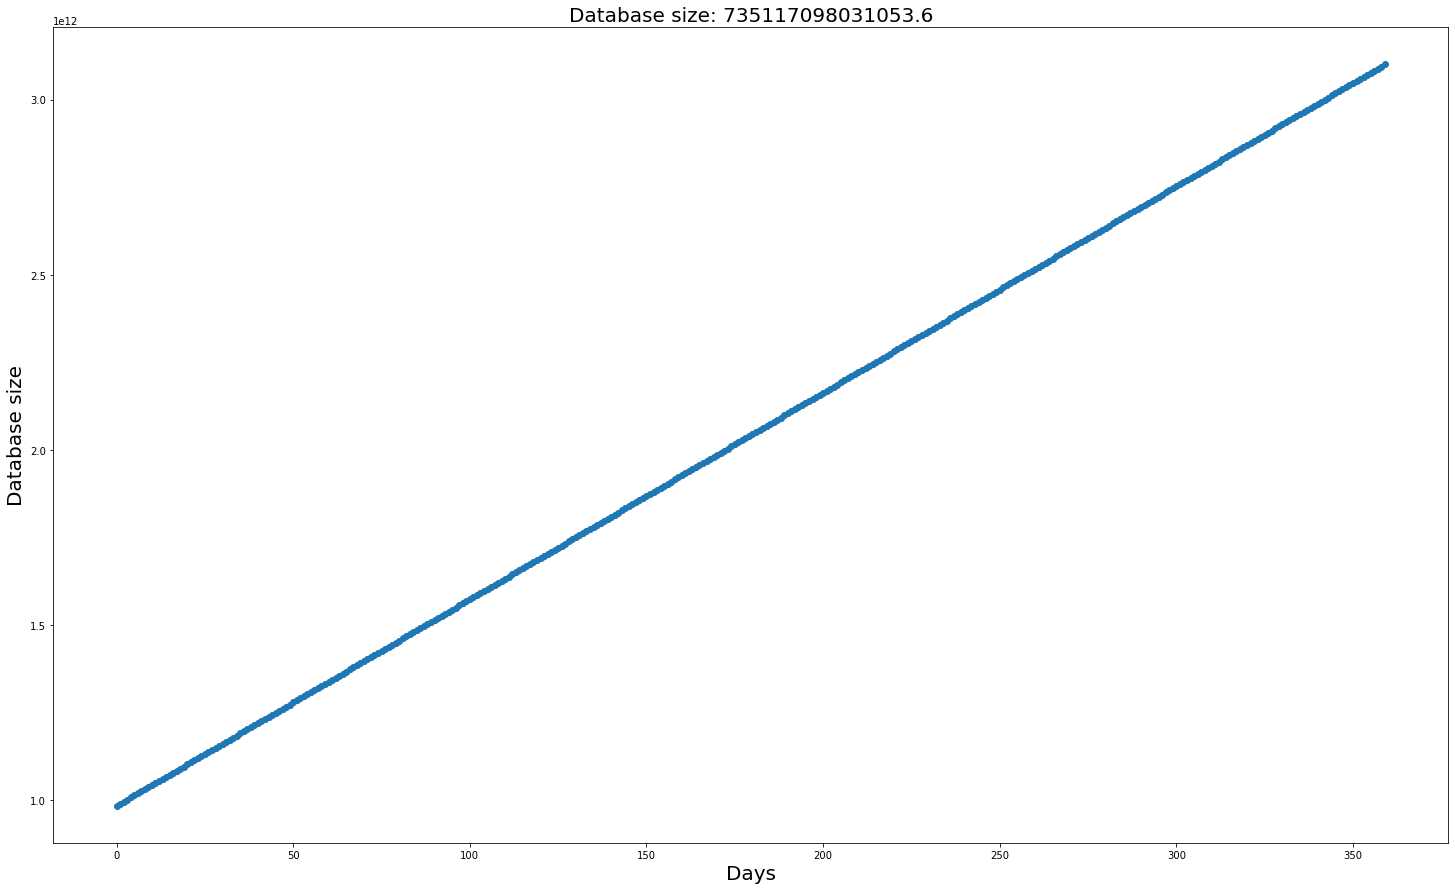

735117098031053.6

In [314]:
database_size(360)

In [336]:
%time
def excess():
    
    #диска почему-то не хватает
    disk_size = 963085224 * 20024
    db_size_in_one_day = database_size(1)
    difference = disk_size/ db_size_in_one_day
    
    if database_size(difference) > disk_size:
        print(database_size(int(difference)) - disk_size, difference)
        if database_size(difference - 1) < disk_size:
            print("sssss")
    

Wall time: 0 ns


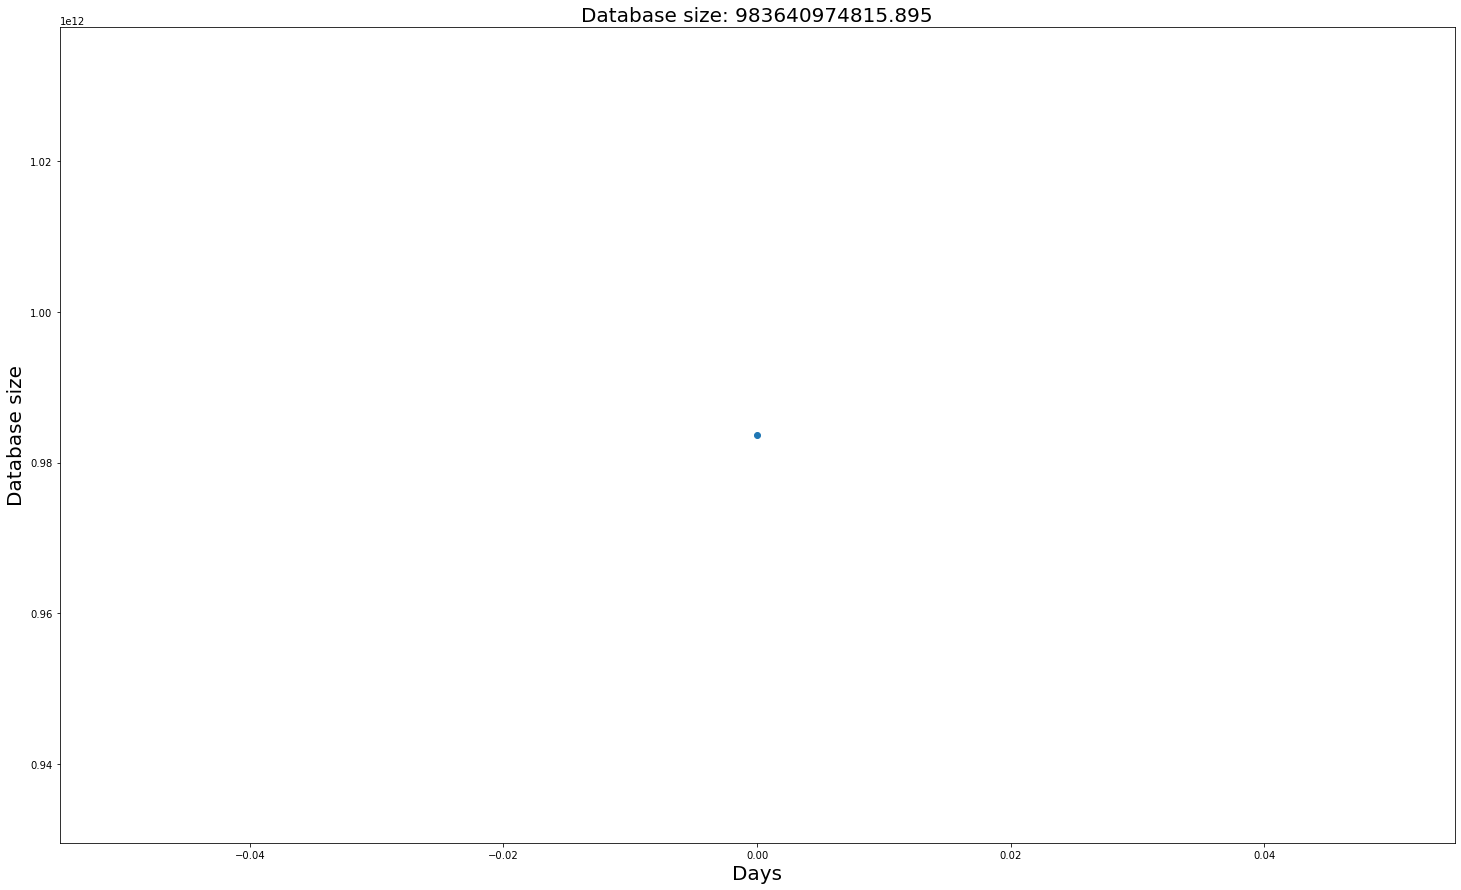

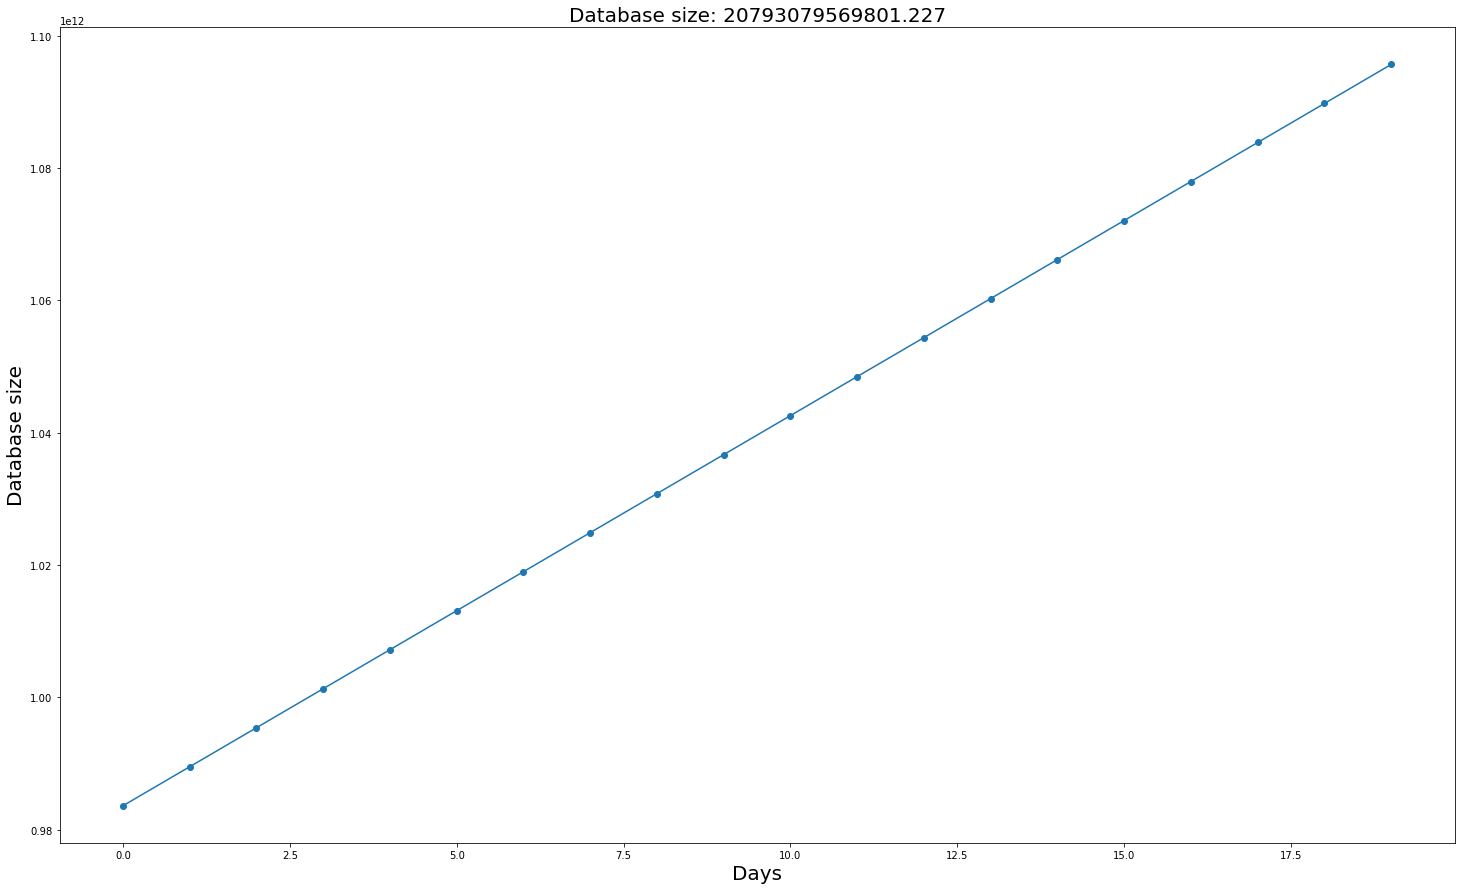

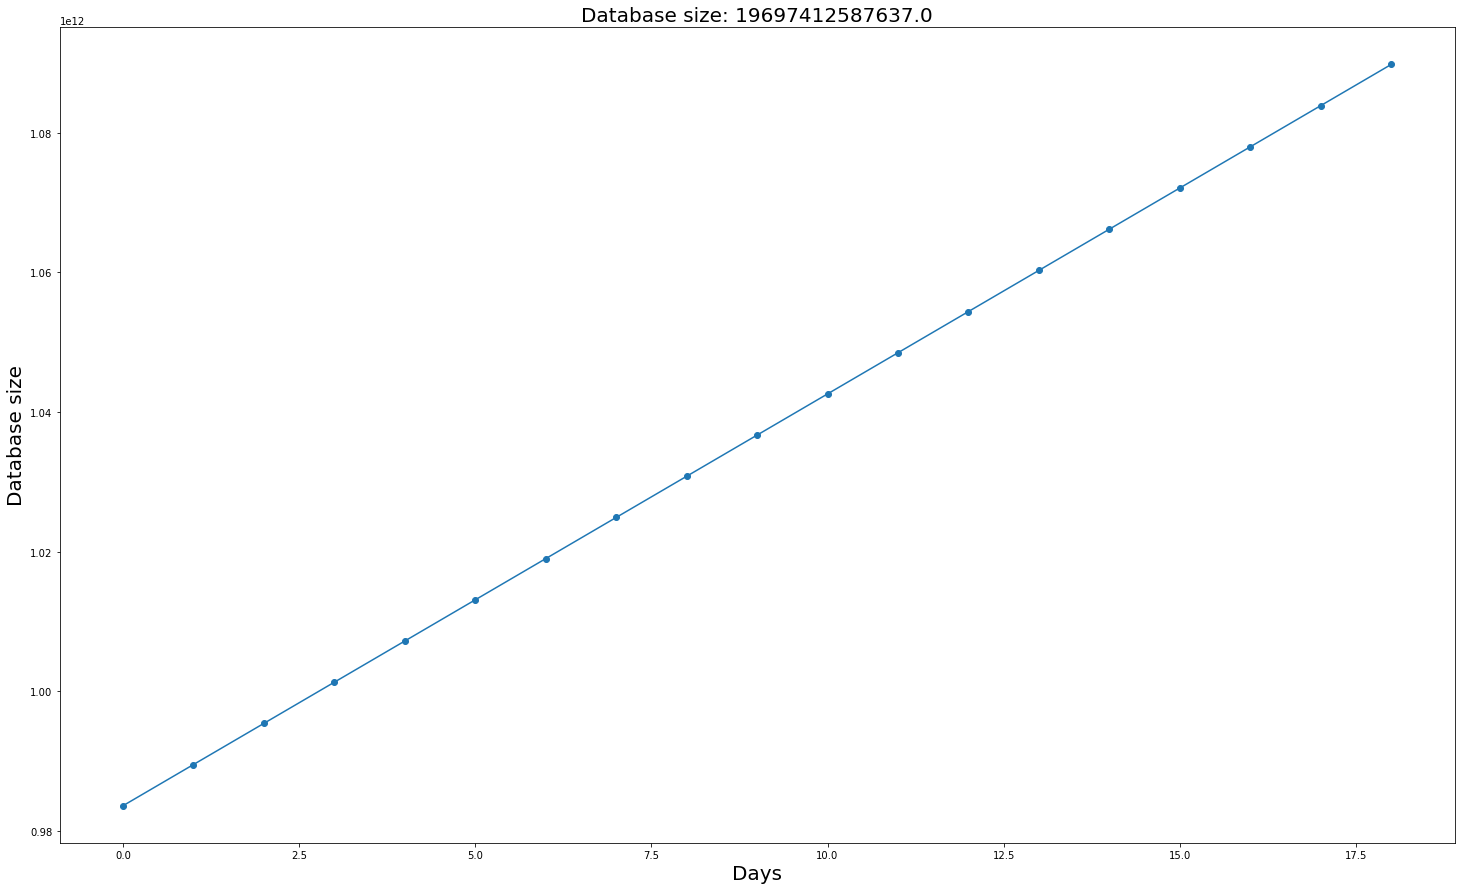

412594062261.0 19.605546148568564


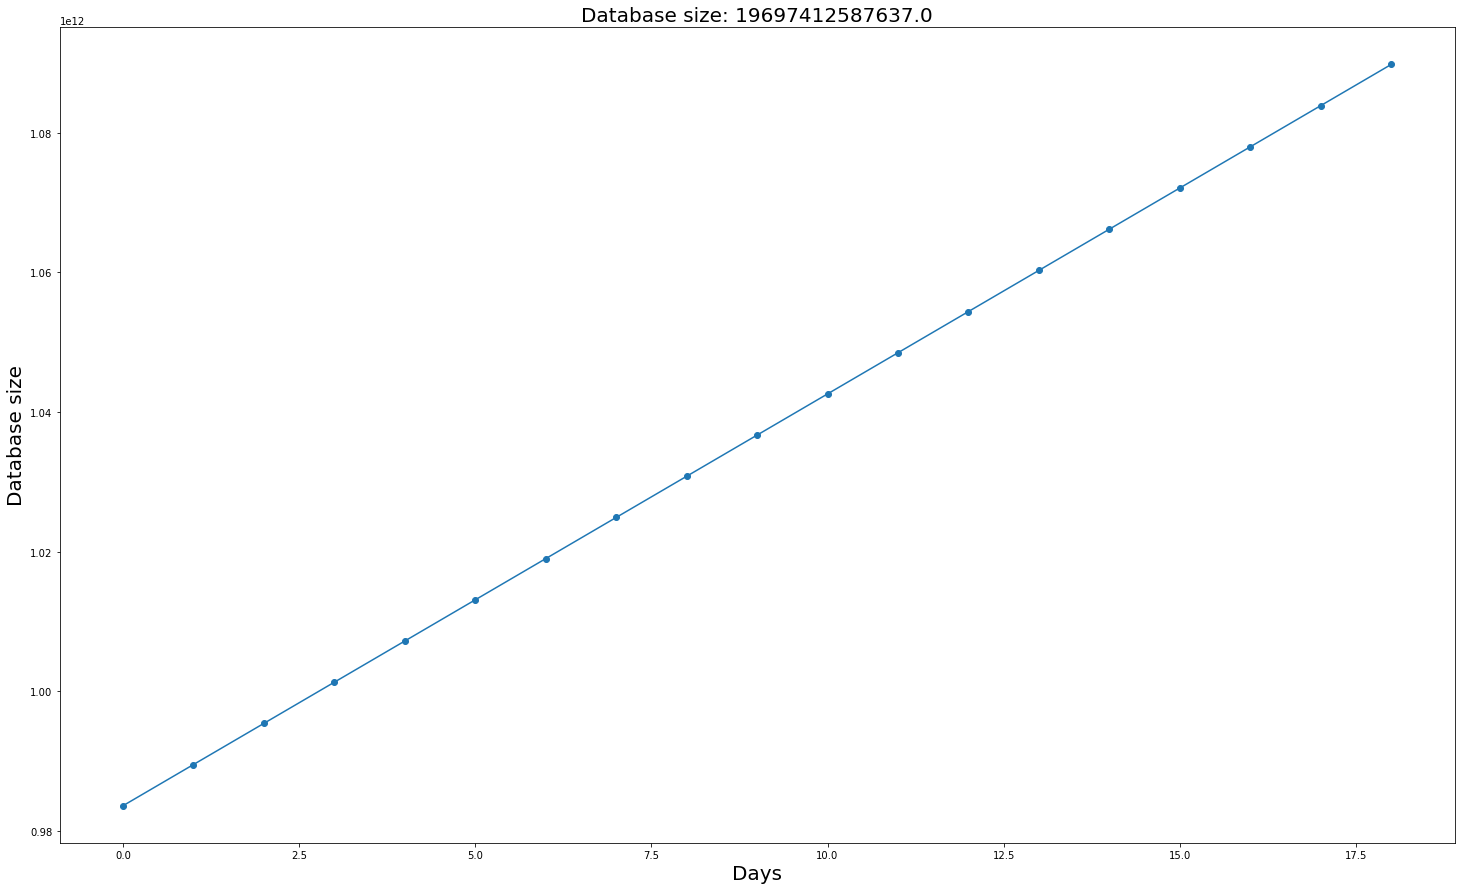

In [337]:
excess()